# Config

In [1]:
# Set dark mode as default
import matplotlib.pyplot as plt
import plotly.io as pio

plt.style.use("dark_background")
pio.templates.default = "plotly_dark"

# Imports
from itertools import combinations, product
from warnings import catch_warnings, filterwarnings
import numpy as np
import pandas as pd
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    make_scorer,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    log_loss,
)
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from market_regime.data import get_data
from market_regime.features.utils import calculate_log_returns, validate_df
from market_regime.features import TreeClassifierFeatureBuilder
from market_regime.models import XGBTreeModel
from market_regime.pipelines.base import RegimePipeline

# Data

## import

In [2]:
# Data import (with labels)
df = get_data()

## data exploration / feature creation

In [3]:
df_train = df[df["delivery_date"] < "2019-01-01"].copy()

In [4]:
df_train["log_returns_t"] = calculate_log_returns(df_train, close_col="close_t", open_col="open_t")

<Axes: xlabel='trading_date'>

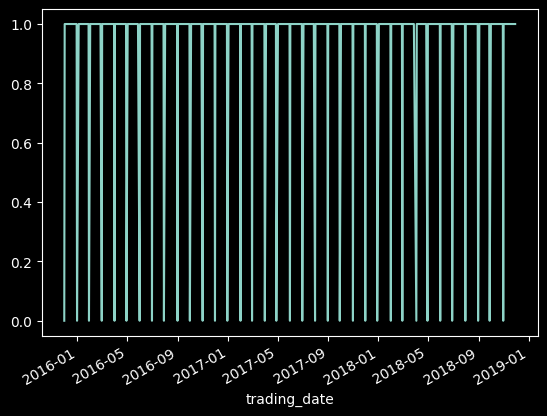

In [5]:
(df_train["delivery_date"] == df_train["delivery_date"].shift(1)).astype(int).plot()

In [6]:
df_train["delivery_date"].dt.month.astype("category")

trading_date
2015-11-30     1
2015-12-01     1
2015-12-02     1
2015-12-03     1
2015-12-04     1
              ..
2018-11-23    12
2018-11-26    12
2018-11-27    12
2018-11-28    12
2018-11-29    12
Name: delivery_date, Length: 768, dtype: category
Categories (12, int32): [1, 2, 3, 4, ..., 9, 10, 11, 12]

In [7]:
for window in [5, 10, 20]: 
    df_train[f"lr_sum_{window}"] = df_train["log_returns_t"].rolling(window=window, min_periods=window).sum()
    df_train[f"lr_std_{window}"] = df_train["log_returns_t"].rolling(window=window, min_periods=window).std()
    for lag in range(1, 4):
        df_train[f"lr_sum_{window}_lag_{lag*window}"] = df_train[f"lr_sum_{window}"].shift(lag*window)
        df_train[f"lr_std_{window}_lag_{lag*window}"] = df_train[f"lr_std_{window}"].shift(lag*window)

for lag in range(1, 6):
    df_train[f"lr_lag_{lag}"] = df_train["log_returns_t"].shift(lag)
    df_train[f"lr2_lag_{lag}"] = (df_train["log_returns_t"]**2).shift(lag)

<Axes: xlabel='trading_date'>

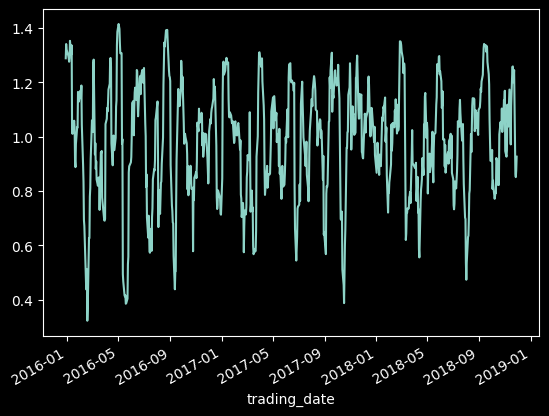

In [8]:
(df_train["lr_std_10"] / df_train["lr_std_20"]).plot()

## function that calculates all the features

In [9]:
tcfb = TreeClassifierFeatureBuilder()

In [10]:
x, y, idx, features = tcfb.build_features(df=df_train, is_train=True)

In [11]:
df_x = pd.DataFrame(x, index=idx, columns=features)

## feature importance

In [12]:
df_x.isna().sum().sum()

np.int64(0)

In [13]:
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(df_x, y)
x_selected = df_x.loc[:, selector.get_support()]
x_selected.columns

Index(['close_min_5', 'close_max_5', 'close_min_10', 'close_max_10',
       'close_ewma_20', 'close_min_20', 'close_max_20', 'lr_std_40',
       'lr_std_40_lag_40', 'lr_std_40_lag_80', 'close_ewma_40', 'close_min_40',
       'close_max_40', 'lr_std_60', 'lr_std_60_lag_60', 'lr_std_60_lag_120',
       'lr_std_60_lag_180', 'close_ewma_60', 'close_min_60', 'close_max_60'],
      dtype='object')

In [14]:
pd.Series(mutual_info_classif(df_x, y), index=df_x.columns).sort_values(ascending=False)

close_min_20            0.552657
close_max_20            0.519891
close_min_40            0.480154
close_min_60            0.478924
close_min_10            0.451838
                          ...   
price_move_id           0.001064
lr_sum_5_lag_10         0.000000
close_range_pos_5       0.000000
day_of_week             0.000000
contract_change_flag    0.000000
Length: 100, dtype: float64

In [15]:
df_x.join(pd.Series(y, index=idx, name="target")).dropna().corr(method="spearman")["target"].sort_values(ascending=False)

target               1.000000
lr_sum_60_lag_180    0.273596
close_to_max_20      0.233829
close_to_max_60      0.220719
close_to_max_10      0.204100
                       ...   
lr_std_10_lag_10    -0.365792
lr_std_5_lag_5      -0.381009
lr_std_5            -0.387918
lr_std_10           -0.432332
lr_std_20           -0.456846
Name: target, Length: 101, dtype: float64

# Hiperparamter tuning

Random search is performed on the first three years of data.

This leaves 1537 obs for out of sample model evaluation.

## XGB

In [16]:
x.shape

(529, 100)

In [17]:
y.shape

(529,)

In [45]:
def remap_labels(y: np.ndarray) -> tuple[np.ndarray, dict[int, int], dict[int, int]]:
    """Map labels from {-1,0,1} -> {0,1,2} for XGBoost multiclass."""
    y = np.asarray(y)
    uniq = np.unique(y)
    if not np.array_equal(uniq, np.array([-1, 0, 1])):
        raise ValueError(
            f"Expected y to contain exactly [-1,0,1]. Got {uniq.tolist()}."
        )

    forward = {-1: 0, 0: 1, 1: 2}
    backward = {v: k for k, v in forward.items()}
    y_mapped = np.vectorize(forward.get)(y)
    return y_mapped.astype(int), forward, backward


def build_random_search(
    random_state: int = 333, n_jobs: int = -1
) -> RandomizedSearchCV:
    """
    Build RandomizedSearchCV for XGBClassifier for time series, using
    TimeSeriesSplit(gap=20).
    """
    tscv = TimeSeriesSplit(n_splits=5, gap=20)
    scorer = make_scorer(f1_score, average="macro")

    base_model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=random_state,
        n_jobs=1,  # this should always be 1! parallelism handled by RandomizedSearchCV
        verbosity=0,
    )

    param_distributions = {
        "max_depth": [2, 3, 4],
        "min_child_weight": loguniform(1, 20),
        "gamma": loguniform(1e-3, 10),
        "subsample": uniform(0.4, 0.6),
        "colsample_bytree": uniform(0.2, 0.6),
        "colsample_bynode": uniform(0.2, 0.6),
        "learning_rate": loguniform(0.005, 0.1),
        "n_estimators": [300, 600, 1000],
        "reg_alpha": loguniform(1e-3, 20),
        "reg_lambda": loguniform(1, 50),
        "max_delta_step": [0, 1, 5],
    }

    rs = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=1000,
        scoring=scorer,
        cv=tscv,
        n_jobs=n_jobs,
        verbose=2,
        random_state=random_state,
        refit=True,
        return_train_score=False,
    )
    return rs


def fit_xgb_timeseries_search(
    X: np.ndarray,
    y: np.ndarray,
    *,
    use_class_weights: bool = True,
    random_state: int = 333,
    n_jobs: int = -1,
) -> tuple[RandomizedSearchCV, dict[int, int], dict[int, int]]:
    """
    Fit RandomizedSearchCV for time series XGBClassifier with gap=20.

    Args:
        X: shape (n_samples, n_features)
        y: shape (n_samples,), values in {-1, 0, 1}
        use_class_weights: if True, uses per-sample weights based on class frequency
            (computed on full y; not fold-only).
    Returns:
        (search, forward_label_map, backward_label_map)
    """
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError(f"X must be 2D. Got shape {X.shape}.")

    y_mapped, forward, backward = remap_labels(y)

    rs = build_random_search(random_state=random_state, n_jobs=n_jobs)

    fit_params = {}
    if use_class_weights:
        sample_weight = compute_sample_weight(class_weight="balanced", y=y_mapped)
        fit_params["sample_weight"] = sample_weight

    rs.fit(X, y_mapped, **fit_params)
    return rs, forward, backward


rs, forward, backward = fit_xgb_timeseries_search(
    x, y, use_class_weights=True, n_jobs=-1
)
print("Best score:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best score: 0.2848754428708983
Best params: {'colsample_bynode': np.float64(0.7101835488506227), 'colsample_bytree': np.float64(0.33161088027641183), 'gamma': np.float64(2.051246250768306), 'learning_rate': np.float64(0.03011587247699289), 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': np.float64(1.8389700598043037), 'n_estimators': 600, 'reg_alpha': np.float64(0.015706362104624578), 'reg_lambda': np.float64(1.8216372774536111), 'subsample': np.float64(0.6808274863049215)}


# OOS Prediction

In [18]:
best_params = {
    "colsample_bynode": np.float64(0.7101835488506227),
    "colsample_bytree": np.float64(0.33161088027641183),
    "gamma": np.float64(2.051246250768306),
    "learning_rate": np.float64(0.03011587247699289),
    "max_delta_step": 1,
    "max_depth": 3,
    "min_child_weight": np.float64(1.8389700598043037),
    "n_estimators": 600,
    "reg_alpha": np.float64(0.015706362104624578),
    "reg_lambda": np.float64(1.8216372774536111),
    "subsample": np.float64(0.6808274863049215),
}

In [34]:
rp = RegimePipeline(
    feature_builder=TreeClassifierFeatureBuilder(), estimator=XGBTreeModel(**best_params)
)
# I'm allowing tail here before 2019-01-01 for rollings and lags, later prediction is cut to 2019
oos_days = df[df["delivery_date"] >= "2018-05-01"].index
preds = []
i = 0
for d in tqdm(oos_days, desc="OOS Prediction:"):
    pos = df.index.get_loc(d)
    if pos <= 20:
        continue
    train_end = df.index[pos - 21]   # last date whose label is fully determined before d
    df_train = df.loc[:train_end, :]
    df_test = df.loc[:d, :]    # because of tail calculations it not only includes `d` but also full history
    rp.fit(df_train)
    full_pred = rp.predict(df_test)
    if d in full_pred.index:
        pred = full_pred.loc[[d]]
    else:
        pred = pd.Series([np.nan], index=[d], name="prediction")
    preds.append(pred)
oos_pred = pd.concat(preds).sort_index()

OOS Prediction::   0%|          | 0/1710 [00:00<?, ?it/s]

In [35]:
oos_pred = oos_pred.loc["2018-11-30":]

## validation

In [37]:
y_true = df.loc[oos_pred.index, "target"].astype(int)
y_pred = oos_pred.astype(int)

macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
bal_acc = balanced_accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
cm_df = pd.DataFrame(cm, index=["true_-1", "true_0", "true_1"], columns=["pred_-1", "pred_0", "pred_1"])

print(f"OOS Macro-F1:          {macro_f1:.4f}")
print(f"OOS Balanced Accuracy: {bal_acc:.4f}\n")

print("Confusion matrix (rows=true, cols=pred):")
display(cm_df)

print("\nClass distribution:")
print("y_true:\n", y_true.value_counts(normalize=True).sort_index())
print("\ny_pred:\n", y_pred.value_counts(normalize=True).sort_index())

print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=[-1, 0, 1], zero_division=0))

# small preview
oos_eval = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
display(oos_eval.head(20))

OOS Macro-F1:          0.3437
OOS Balanced Accuracy: 0.3426

Confusion matrix (rows=true, cols=pred):


,pred_-1,pred_0,pred_1
true_-1,272,243,100
true_0,227,137,128
true_1,185,113,132



Class distribution:
y_true:
 target
-1    0.400130
 0    0.320104
 1    0.279766
Name: proportion, dtype: float64

y_pred:
 prediction
-1    0.445023
 0    0.320755
 1    0.234223
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

          -1       0.40      0.44      0.42       615
           0       0.28      0.28      0.28       492
           1       0.37      0.31      0.33       430

    accuracy                           0.35      1537
   macro avg       0.35      0.34      0.34      1537
weighted avg       0.35      0.35      0.35      1537



,y_true,y_pred
trading_date,,
2018-11-30,-1,-1
2018-12-03,-1,-1
2018-12-04,-1,-1
2018-12-05,-1,-1
2018-12-06,0,-1
2018-12-07,-1,-1
2018-12-10,0,-1
2018-12-11,0,-1
2018-12-12,-1,-1
